
# Modellimi në Fizikë – Notebook 0.1  
## Pse llogaritja numerike? Paradigmat kryesore dhe shembull i zgjeruar (nga Notebook → Kod prodhimi)

**Qëllimi pedagogjik:** Ky notebook shërben si “urë” midis të mësuarit me *Jupyter Notebooks* dhe mënyrës se si shkruhet kodi në nivel **profesional / prodhimi**.  
Ne do të punojmë në dy pjesë:

1. **Pjesa A (Konceptualizim + shembuj të shkurtër):** Pse bëjmë llogaritje numerike dhe cilat janë paradigmat kryesore të modelimit/shkencës kompjuterike në fizikë.  
2. **Pjesa B (Shembull i zgjeruar):** Marrim një shembull (oscilatori harmonik) dhe e zhvillojmë: nga formulimi fizik → integratorë → analiza e gabimit → ide se si strukturohet kodi “si në prodhim”.

> **Shënim:** Në një kurs modelimi, notebook-u është laborator: shpejt për eksperimentim, por gjithmonë me synimin që kodin ta ristrukturojmë në funksione/module të testueshme.



### Çfarë do të mësojmë këtu

- Pse metodat numerike janë thelbësore në Fizikë (kur metodat analitike nuk mjaftonë).
- Paradigmat kryesore:
  - **Simulimi** (forward modeling),
  - **Optimizimi** (kalibrimi i parametrave),
  - **Invertimi ose inferenca** (nga të dhënat tek parametrat/hipotezat),
  - **Metodat Stokastike & Monte Carlo**,
  - **Metodat e Diskretizimit të fushave** (PDE → ODE/algoritme).
- Në shembullin e zgjeruar:
  - ODE e oscilatorit harmonik,
  - Euler, RK4 dhe një **integrator simetrik** (Verlet / symplectic),
  - Krahasimi i gabimit dhe drift-it të energjisë,
  - Si kalojmë nga “kod në qeliza” në një strukturë profesionale (funksione, konfigurim, testim minimal).



---
## Pjesa A — Pse llogaritje numerike? Paradigmat kryesore

### 1) Kur na duhet numerika?

Në praktikë, shumë sisteme fizike prodhojnë ekuacione që:

- nuk kanë zgjidhje të mbyllur analitike (p.sh. jo-linearitet i fortë),
- janë shumë-dimensionale (shumë shkallë lirie),
- përfshijnë kufij/kushte të ndërlikuara,
- përfshijnë sinjal stokastik (zhurmë, difuzion, procese Markoviane),
- kërkojnë kalibrim parametrash apo optimizim.

Prandaj, numerika është një *metodë epistemologjike*: na lejon të eksplorojmë, verifikojmë hipoteza dhe ndërtojmë intuitë fizike.



### 2) Paradigmat kryesore të llogaritjes numerike në modelim

#### (a) Simulim / Forward modeling
Japim parametrat dhe kushtet fillestare, dhe llogarisim evolucionin:  
$
\text{parametra} \;\rightarrow\; \text{trajektore / fushë / madhësi të matëshme}.
$

#### (b) Optimizim (kalibrim parametrash)
Përzgjedhim parametrat që minimizojnë një funksion kostoje:

$
\theta^{*} = \arg\min_{\theta} \; \mathcal{L}(\theta).
$

#### (c) Problem invers ose inferenca
Nga të dhënat, duam të nxjerrim parametrat ose strukturën e modelit:

$
\text{të dhëna} \;\rightarrow\; \text{parametra / hipoteza}.
$
Këtu futet edhe statistika Bayesiane (posteriori, besueshmëri, intervale).

#### (d) Monte Carlo / Stokastika
Kur sistemet kanë zhurmë:

$
\mathbb{E}[f(X)] \approx \frac{1}{N}\sum_{i=1}^N f(X_i).
$

#### (e) Metoda Diskretizimi të fushave (PDE)
Shumë probleme në fizikë janë PDE (p.sh. difuzioni, Navier–Stokes). Zakonisht i kthejmë në sisteme algjebrike/ODE përmes:
- diferencave të fundme,
- elementeve të fundme,
- metodave spektrale.



### 3) Shembuj shumë të shkurtër (për të fiksuar intuitën)

Më poshtë japim disa “mikro-shembuj” që tregojnë paradigmat, pa u futur ende në detaje të thella.


In [1]:

import numpy as np

# (a) Simulim: ODE e thjeshtë d x / dt = -k x  (relaksim)
def simulate_relaxation(k=1.0, x0=1.0, t_end=5.0, dt=0.01):
    t = np.arange(0.0, t_end + dt, dt)
    x = np.zeros_like(t)
    x[0] = x0
    for n in range(len(t) - 1):
        x[n+1] = x[n] + dt * (-k * x[n])  # Euler
    return t, x

t, x = simulate_relaxation(k=1.2, x0=1.0)
x[-1], x[0]


(np.float64(0.002390409432276832), np.float64(1.0))

In [2]:

# (b) Optimizim: gjej k që përshtatet me "të dhëna" sintetike të relaksimit
# Kjo është një ilustrim minimal; më vonë do të përdorim mjete më të mira (p.sh. scipy.optimize)

def loss_for_k(k, t_data, x_data, x0, dt):
    t_sim, x_sim = simulate_relaxation(k=k, x0=x0, t_end=t_data[-1], dt=dt)
    return float(np.mean((x_sim[:len(t_data)] - x_data)**2))

# Të dhëna sintetike
rng = np.random.default_rng(0)
t_data = np.arange(0, 5.0+0.01, 0.01)
k_true = 1.5
_, x_true = simulate_relaxation(k=k_true, x0=1.0, t_end=5.0, dt=0.01)
x_data = x_true + 0.02 * rng.standard_normal(len(x_true))  # zhurmë

# kërkim i thjeshtë në rrjetë
k_grid = np.linspace(0.5, 2.5, 81)
losses = [loss_for_k(k, t_data, x_data, x0=1.0, dt=0.01) for k in k_grid]
k_hat = k_grid[int(np.argmin(losses))]

k_true, k_hat, min(losses)


(1.5, np.float64(1.5), 0.00041175648476460204)


> Vërejtje: Këto janë ilustrime minimale. Në praktikë, do të përdorim biblioteka standarde (SciPy) dhe do të diskutojmë kujdesin numerik (stabilitet, gabime, identifikueshmëri).

Tani kalojmë në Pjesën B: një shembull të zgjeruar ku shohim si ndryshon sjellja fizike sipas integratorit.



---
## Pjesa B — Shembull i zgjeruar: Oscilatori harmonik dhe integratorët

### 1) Modeli fizik

Oscilatori harmonik (pa fërkim) përshkruhet nga:
\[
\ddot{x} + \omega^2 x = 0.
\]

E kthejmë në sistem të rendit të parë:
\[
\dot{x} = v,\qquad \dot{v} = -\omega^2 x.
\]

Energjia totale (që duhet të ruhet në teori) është:
\[
E = \frac{1}{2}v^2 + \frac{1}{2}\omega^2 x^2.
\]

**Qëllim numerik:** të shohim si integratorë të ndryshëm ndikojnë në:
- gabimin në trajektore,
- ruajtjen e energjisë (drift),
- stabilitetin afatgjatë.


In [3]:

import numpy as np
import matplotlib.pyplot as plt

def energy(x, v, omega):
    return 0.5 * v**2 + 0.5 * (omega**2) * x**2

def f_state(state, omega):
    # state = [x, v]
    x, v = state
    return np.array([v, -(omega**2) * x], dtype=float)

def integrate_euler(state0, omega, t_end, dt):
    t = np.arange(0.0, t_end + dt, dt)
    y = np.zeros((len(t), 2), dtype=float)
    y[0] = state0
    for n in range(len(t)-1):
        y[n+1] = y[n] + dt * f_state(y[n], omega)
    return t, y

def integrate_rk4(state0, omega, t_end, dt):
    t = np.arange(0.0, t_end + dt, dt)
    y = np.zeros((len(t), 2), dtype=float)
    y[0] = state0
    for n in range(len(t)-1):
        k1 = f_state(y[n], omega)
        k2 = f_state(y[n] + 0.5*dt*k1, omega)
        k3 = f_state(y[n] + 0.5*dt*k2, omega)
        k4 = f_state(y[n] + dt*k3, omega)
        y[n+1] = y[n] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return t, y

def integrate_velocity_verlet(state0, omega, t_end, dt):
    t = np.arange(0.0, t_end + dt, dt)
    y = np.zeros((len(t), 2), dtype=float)
    y[0] = state0
    x, v = state0
    for n in range(len(t)-1):
        a = -(omega**2) * x
        x_new = x + v*dt + 0.5*a*dt*dt
        a_new = -(omega**2) * x_new
        v_new = v + 0.5*(a + a_new)*dt
        x, v = x_new, v_new
        y[n+1] = [x, v]
    return t, y

omega = 2.0
state0 = np.array([1.0, 0.0])  # x0=1, v0=0
t_end = 50.0
dt = 0.05

t_e, y_e = integrate_euler(state0, omega, t_end, dt)
t_r, y_r = integrate_rk4(state0, omega, t_end, dt)
t_v, y_v = integrate_velocity_verlet(state0, omega, t_end, dt)

E_e = energy(y_e[:,0], y_e[:,1], omega)
E_r = energy(y_r[:,0], y_r[:,1], omega)
E_v = energy(y_v[:,0], y_v[:,1], omega)

E0 = float(energy(state0[0], state0[1], omega))
E0


2.0


### 2) Krahasimi i trajektoreve

Në intervale të gjata kohe, Euler zakonisht sjell rritje artificiale të energjisë (ose ulje, në varësi të problemit), ndërsa RK4 është i saktë lokalish, por jo domosdoshmërisht “strukturë-ruajtës”. Integratori simetrik (Verlet) priret të ruajë më mirë energjinë në kohë të gjatë.


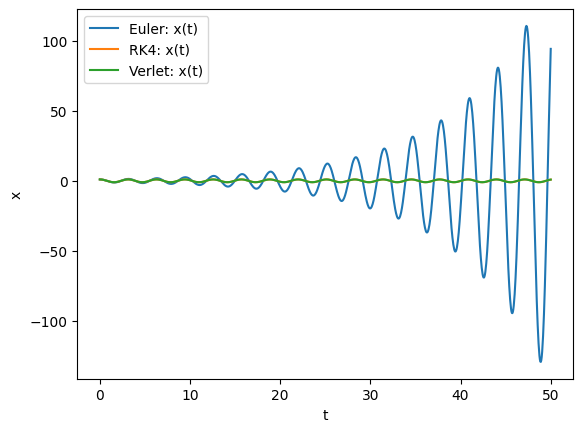

In [4]:

plt.figure()
plt.plot(t_e, y_e[:,0], label="Euler: x(t)")
plt.plot(t_r, y_r[:,0], label="RK4: x(t)")
plt.plot(t_v, y_v[:,0], label="Verlet: x(t)")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()



### 3) Ruajtja e energjisë: drift numerik

Këtu shohim një kriter shumë praktik: **sa e ruan energjinë** integratori.
Në sisteme Hamiltoniane, ruajtja e strukturës shpesh është po aq e rëndësishme sa saktësia lokale.


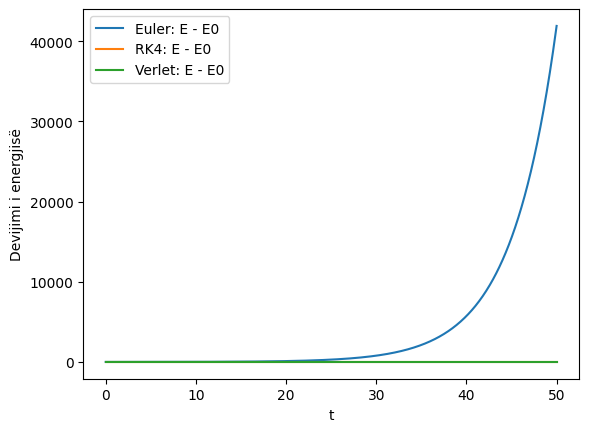

(41916.311275627435, -2.7742863331070566e-05, -0.0011043362423670544)

In [5]:

plt.figure()
plt.plot(t_e, E_e - E0, label="Euler: E - E0")
plt.plot(t_r, E_r - E0, label="RK4: E - E0")
plt.plot(t_v, E_v - E0, label="Verlet: E - E0")
plt.xlabel("t")
plt.ylabel("Devijimi i energjisë")
plt.legend()
plt.show()

float(E_e[-1]-E0), float(E_r[-1]-E0), float(E_v[-1]-E0)



---
## Nga Notebook → Kod profesional (parime praktike)

Notebook-u është i shkëlqyer për:
- eksplorim,
- vizualizim,
- shpjegim pedagogjik.

Por, në nivel profesional, ne duam:
1. **Funksione të pastra** (input → output, pa efekte anësore të panevojshme),
2. **Ndarje përgjegjësish** (modeli, integratori, analiza, vizualizimi),
3. **Parametrizim** (p.sh. dt, t_end, omega) pa ndryshuar trupin e kodit,
4. **Testim minimal** (p.sh. energjia nuk “fluturon” për dt të vogël),
5. **Dokumentim** (docstrings, tipe, komente të arsyetuara).

### Një “skelet” i thjeshtë prodhimi

Një strukturë e zakonshme (që do ta përdorim gradualisht në repo) mund të jetë:

```
bundle_1/
  notebooks/
    01_paradigmat_dhe_ode.ipynb
  src/
    models.py          # definon f(state, params)
    integrators.py     # euler, rk4, verlet
    diagnostics.py     # energy, error metrics
  tests/
    test_integrators.py
  README.md
```


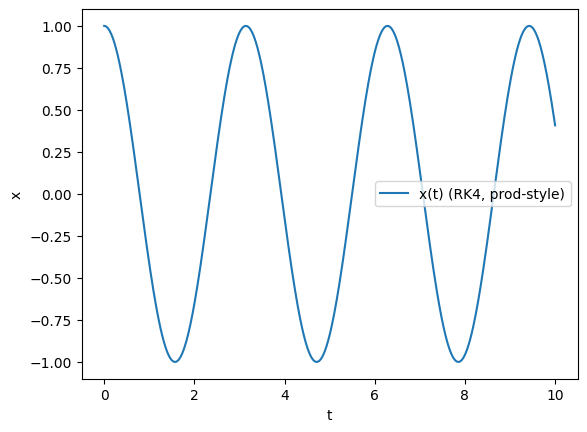

In [6]:

from dataclasses import dataclass
from typing import Callable, Tuple

@dataclass(frozen=True)
class OscillatorParams:
    omega: float

State = np.ndarray  # shape (2,)

def oscillator_rhs(state: State, p: OscillatorParams) -> State:
    x, v = state
    return np.array([v, -(p.omega**2) * x], dtype=float)

def step_rk4(rhs: Callable[[State, OscillatorParams], State],
             state: State,
             p: OscillatorParams,
             dt: float) -> State:
    k1 = rhs(state, p)
    k2 = rhs(state + 0.5*dt*k1, p)
    k3 = rhs(state + 0.5*dt*k2, p)
    k4 = rhs(state + dt*k3, p)
    return state + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def simulate(rhs, stepper, state0: State, p: OscillatorParams, t_end: float, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    t = np.arange(0.0, t_end + dt, dt)
    y = np.zeros((len(t), len(state0)), dtype=float)
    y[0] = state0
    for n in range(len(t)-1):
        y[n+1] = stepper(rhs, y[n], p, dt)
    return t, y

p = OscillatorParams(omega=2.0)
t_s, y_s = simulate(oscillator_rhs, step_rk4, np.array([1.0, 0.0]), p, t_end=10.0, dt=0.01)

plt.figure()
plt.plot(t_s, y_s[:,0], label="x(t) (RK4, prod-style)")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()



### Testim minimal (si ide, jo si zëvendësim i një suite testesh)

Në prodhim, nuk “besojmë” te kodi sepse duket bukur; e verifikojmë me teste minimale.

Shembull: për dt të vogël, devijimi relativ i energjisë pas një kohe të caktuar duhet të jetë i vogël (jo domosdoshmërisht zero).


In [7]:

def rel_energy_drift(y, omega):
    E = energy(y[:,0], y[:,1], omega)
    return float((E[-1] - E[0]) / E[0])

omega = 2.0
state0 = np.array([1.0, 0.0])

# dt e vogël → drift i vogël (për Verlet pritet shumë i mirë)
t_v2, y_v2 = integrate_velocity_verlet(state0, omega, t_end=100.0, dt=0.01)
drift_v = rel_energy_drift(y_v2, omega)

t_e2, y_e2 = integrate_euler(state0, omega, t_end=100.0, dt=0.01)
drift_e = rel_energy_drift(y_e2, omega)

drift_e, drift_v


(53.55450061466955, -7.598058276925279e-05)


---
## Përmbledhje

- Metodat numerike na lejojnë të studiojmë sisteme ku metodat analitika nuk mjaftojnë.
- Paradigmat kryesore: simulim, optimizim, inferencë, Monte Carlo, diskretizim.
- Për oscilatorin harmonik, integratorët ndryshojnë ndjeshëm në ruajtjen e energjisë.
- Notebook-u është mjet pedagogjik dhe laborator; por kodi serioz organizohet në funksione/modula, me parametrizim dhe testim minimal.

### Detyrë e shkurtër (opsionale)
1) Ndryshoni \(dt\) dhe shihni si ndryshon drift-i i energjisë.  
2) Shtoni fërkim: \(\dot{v} = -\omega^2 x - \gamma v\) dhe diskutoni çfarë do të thotë “energji” në këtë rast.  
3) Propozoni një mënyrë për ta paketuar këtë shembull në `src/` dhe si do ta testonit.

---
**Notebook-u i ardhshëm (Part_1):** themelet e ODE solver-ave, stabiliteti numerik dhe praktikat e punës me repo.
